In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from arch.univariate import arch_model
import scipy.stats as ss

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("bmh")

In [2]:
data = pd.read_csv('USDCAD_100101_200904.csv', sep = ';')

In [3]:
data.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,USDCAD,D,20100101,0,1.0527,1.0534,1.0522,1.0517,0
1,USDCAD,D,20100104,0,1.0517,1.0521,1.0352,1.0416,0
2,USDCAD,D,20100105,0,1.0410,1.0421,1.0334,1.0381,0
3,USDCAD,D,20100106,0,1.0388,1.0410,1.0313,1.0318,0
4,USDCAD,D,20100107,0,1.0320,1.0374,1.0292,1.0343,0


In [4]:
data.rename(columns={'<DATE>': 'Date', '<CLOSE>': 'Price'}, inplace = True)
data['Date'] = pd.to_datetime(data['Date'].astype(str), format='%Y%m%d')
data.index = data['Date']
data.index = data.index.to_period(freq='d')
data = data[['Price']]

In [5]:
data['Returns'] = 100 * data['Price'].pct_change()

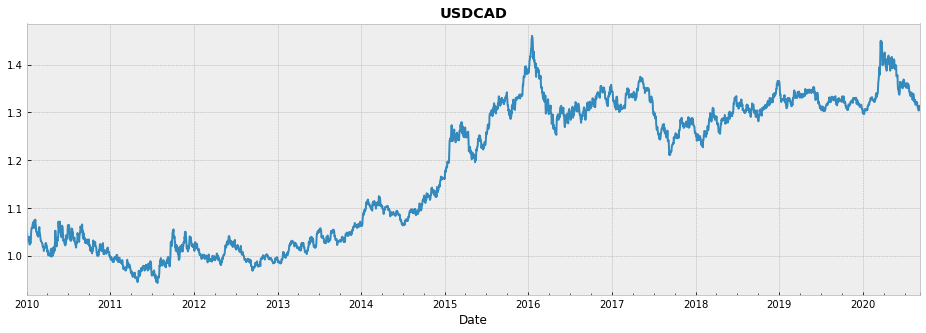

In [7]:
fig = plt.figure(figsize=(16, 5))

data['Price'].plot()
plt.title("USDCAD", weight="bold")

plt.show()

#### Beta with the market

In [8]:
SP500 = pd.read_csv('SANDP-500_100101_200904.csv', sep = ';')
SP500['<DATE>'] = pd.to_datetime(SP500['<DATE>'].astype(str), format='%Y%m%d')
SP500.index = SP500['<DATE>']
SP500.index = SP500.index.to_period(freq='d')
data['Date'] = data.index

In [9]:
beta_data = SP500.join(data, how = 'inner', lsuffix='_x')
covariance = np.cov(beta_data['Price'],beta_data['<CLOSE>'])
beta = covariance[0,1]/covariance[1,1]
print('Beta between USDCAD and the market is {:0.2f}%, which is below 5%, so'.format(beta*100))
print('our currency pair is not correlated with the market')

Beta between USDCAD and the market is 0.02%, which is below 5%, so
our currency pair is not correlated with the market


### Distribution of returns

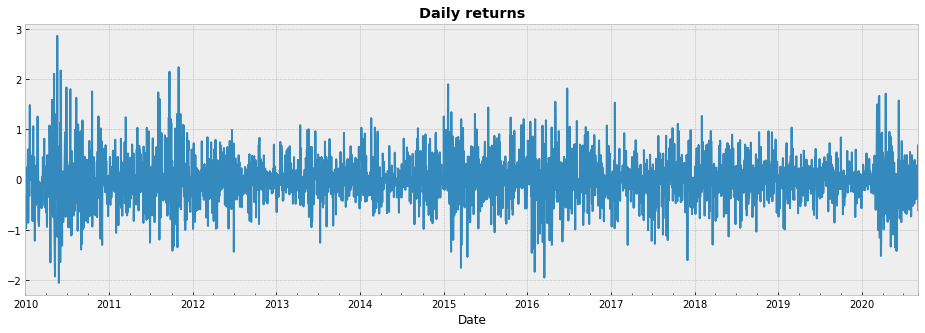

In [10]:
fig = plt.figure(figsize=(16, 5))

data['Returns'].plot()
plt.title("Daily returns", weight="bold")

plt.show()

t-Student distribution

In [11]:
alpha = 0.05
params_t = ss.t.fit(data['Returns'][1:])
t_df, t_mean, t_sigma = params_t

VaR_t = ss.t.ppf(alpha, t_df, t_mean, t_sigma)
ES_t = ss.t.expect(args=(t_df,), loc=t_mean, scale=t_sigma, ub=VaR_t, conditional=True)

print('Estimated parameters: df={:.2f}, mean={:.2f}, scale={:.2f}'.format(t_df, t_mean, t_sigma))
print('Value-at-Risk: {:.2f}%'.format(100*VaR_t))
print('Expected Shortfall: {:.2f}%'.format(100*ES_t))

Estimated parameters: df=2.47, mean=0.00, scale=0.26
Value-at-Risk: -65.86%
Expected Shortfall: -119.43%


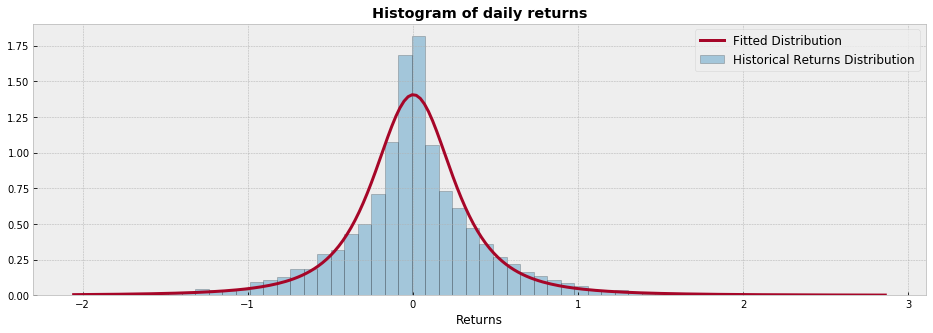

In [12]:
fig = plt.figure(figsize=(16, 5))

x = np.linspace(data['Returns'][1:].min(), data['Returns'][1:].max(), 200)

y_pdf = ss.t.pdf(x, *params_t)

sns.distplot(data['Returns'][1:], hist=True, kde=False, 
             bins=60, norm_hist=True,
             hist_kws={'edgecolor':'black'})
plt.plot(x, y_pdf, linewidth=3)

plt.title("Histogram of daily returns", weight="bold")
plt.legend(['Fitted Distribution', 'Historical Returns Distribution'], fontsize=12)


plt.show()

<Figure size 720x360 with 0 Axes>

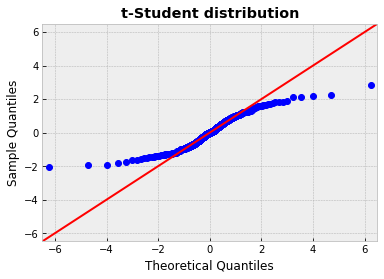

In [13]:
from statsmodels.graphics.gofplots import qqplot
fig = plt.figure(figsize=(10, 5))
qqplot(data['Returns'][1:], dist=ss.t(*params_t), line='45')
plt.title("t-Student distribution", weight="bold")
plt.show()

General normal distribution

In [14]:
alpha = 0.05
params_gennorm = ss.gennorm.fit(data['Returns'][1:])
beta, loc, scale = params_gennorm

VaR_t = ss.gennorm.ppf(alpha, beta, loc=loc, scale=scale)
ES_t = ss.gennorm.expect(args=(beta,), loc=loc, scale=scale, ub=VaR_t, conditional=True)

print('Estimated parameters: beta={:.2f}'.format(beta))
print('Value-at-Risk: {:.2f}%'.format(100*VaR_t))
print('Expected Shortfall: {:.2f}%'.format(100*ES_t))

Estimated parameters: beta=0.79
Value-at-Risk: -70.79%
Expected Shortfall: -108.18%


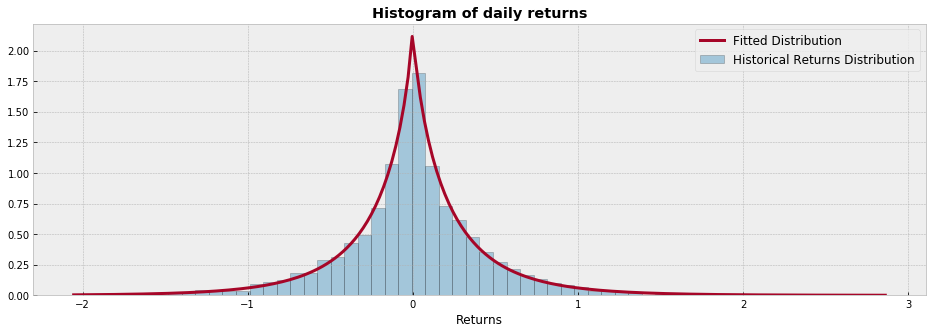

In [15]:
fig = plt.figure(figsize=(16, 5))

x = np.linspace(data['Returns'][1:].min(), data['Returns'][1:].max(), 200)

y_pdf = ss.gennorm.pdf(x, *params_gennorm)

sns.distplot(data['Returns'][1:], hist=True, kde=False, 
             bins=60, norm_hist=True,
             hist_kws={'edgecolor':'black'})
plt.plot(x, y_pdf, linewidth=3)

plt.title("Histogram of daily returns", weight="bold")
plt.legend(['Fitted Distribution', 'Historical Returns Distribution'], fontsize=12)


plt.show()

<Figure size 720x360 with 0 Axes>

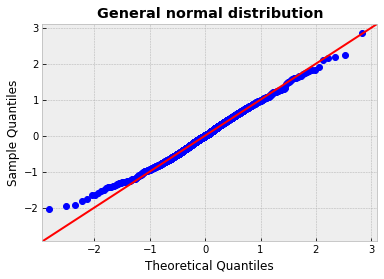

In [16]:
from statsmodels.graphics.gofplots import qqplot
fig = plt.figure(figsize=(10, 5))
qqplot(data['Returns'][1:], dist=ss.gennorm(*params_gennorm), line='45')
plt.title("General normal distribution", weight="bold")
plt.show()

So the returns are distribited via General normal distribution and not by t-Student distribution.

In [17]:
def rolling_window(window_length, alpha = 0.05):
    w = str(window_length)
    data['Filtered_' + w] = np.nan
    data['VaR_' + w] = np.nan
    
    for i in range(len(data)-window_length):
        window = data['Returns'][i:i+window_length]
        am = arch_model(window, mean='AR', lags=1,
                        vol = 'Garch', p=1, o=1, q=1, dist='ged')
        res = am.fit()
        forecasts = res.forecast(horizon=1)
        cond_mean = float(forecasts.mean.iloc[-1])
        cond_var = float(forecasts.variance.iloc[-1])

        day_cleaned = (data['Returns'][i+window_length] - cond_mean)/np.sqrt(cond_var)
        data['Filtered_' + w][i+window_length] = day_cleaned

        q = am.distribution.ppf(alpha, res.params[-1:])
        data['VaR_' + w][i+window_length] = cond_mean + np.sqrt(cond_var) * q


In [ ]:
rolling_window(50, 0.05)

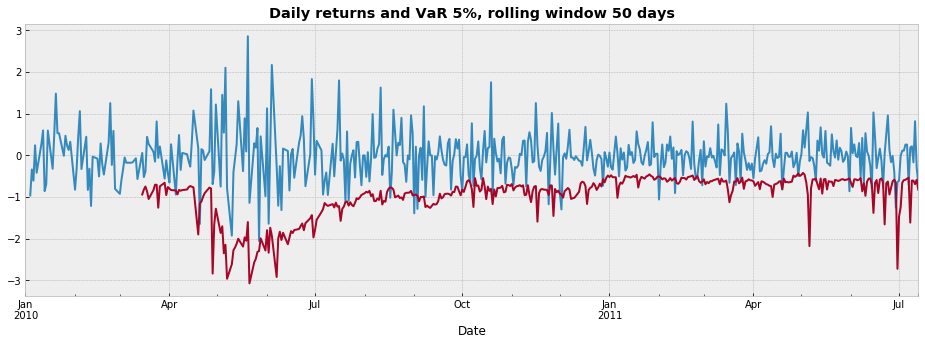

In [20]:
fig = plt.figure(figsize=(16, 5))

ax1=fig.add_subplot(111)
data['Returns'][:500].plot()

ax2=fig.add_subplot(111)
data['VaR_50'][:500].plot()

plt.title("Daily returns and VaR 5%, rolling window 50 days", weight="bold")

plt.show()

In [ ]:
rolling_window(100, 0.05)

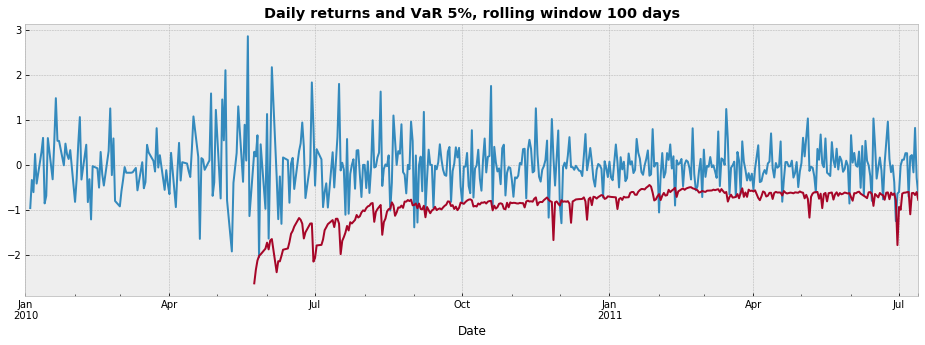

In [49]:
fig = plt.figure(figsize=(16, 5))

ax1=fig.add_subplot(111)
data['Returns'][:500].plot()

ax2=fig.add_subplot(111)
data['VaR_100'][:500].plot()

plt.title("Daily returns and VaR 5%, rolling window 100 days", weight="bold")

plt.show()

In [ ]:
rolling_window(150, 0.05)

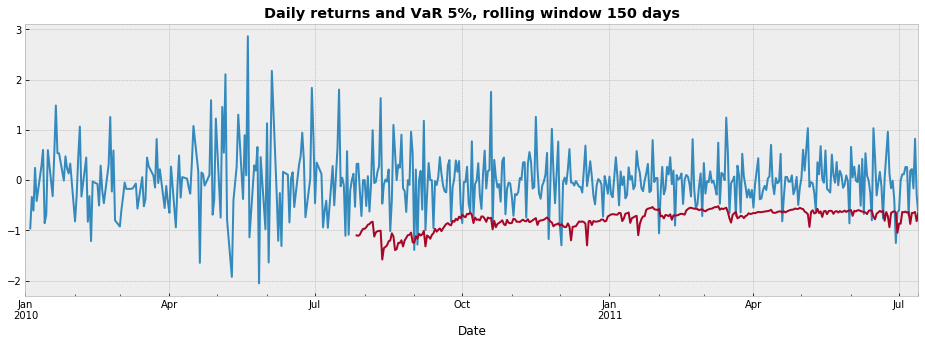

In [53]:
fig = plt.figure(figsize=(16, 5))

ax1=fig.add_subplot(111)
data['Returns'][:500].plot()

ax2=fig.add_subplot(111)
data['VaR_150'][:500].plot()

plt.title("Daily returns and VaR 5%, rolling window 150 days", weight="bold")

plt.show()

In [ ]:
rolling_window(200, 0.05)

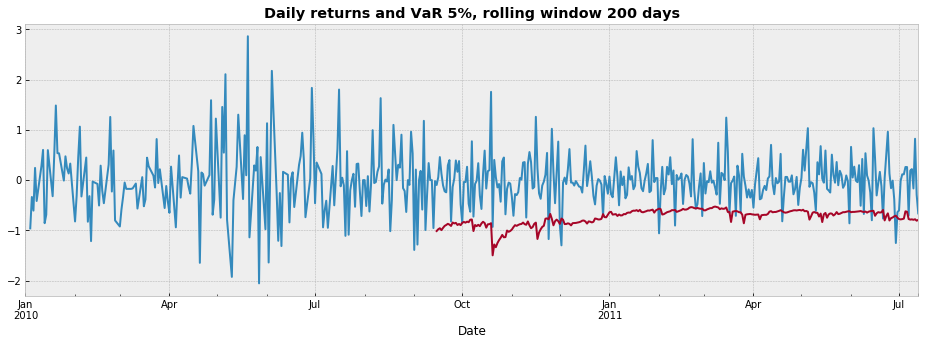

In [55]:
fig = plt.figure(figsize=(16, 5))

ax1=fig.add_subplot(111)
data['Returns'][:500].plot()

ax2=fig.add_subplot(111)
data['VaR_200'][:500].plot()

plt.title("Daily returns and VaR 5%, rolling window 200 days", weight="bold")

plt.show()

### Strategy

In [21]:
def strategy(data, w):
    data['Price_buy'] = np.nan
    data['Price_sell'] = np.nan
    flag = -1
    budjet = 1000000
    stocks = 0
    
    for i in range(len(data)):
        if data['Filtered_' + w][i] > 2:
            if flag != 1:
                data['Price_buy'][i] = data['Price'][i]
                stocks = budjet/(data['Price'][i]*1.001)
                budjet = 0
                flag = 1
        elif data['Filtered_' + w][i] < -2:
            if flag != -1:
                data['Price_sell'][i] = data['Price'][i]
                budjet = stocks*data['Price'][i]*0.999
                stocks = 0
                flag = -1
    if budjet != 0:
        return budjet
    return stocks * data['Price'][-1]

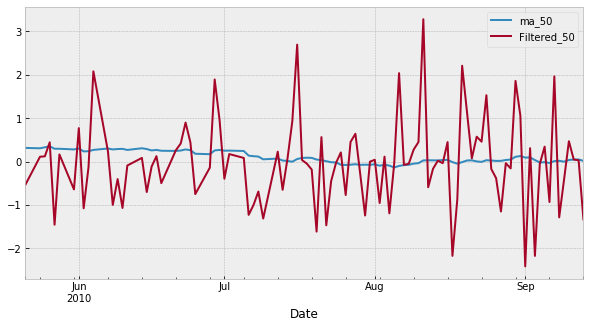

In [22]:
data['ma_50'] = data['Filtered_50'].rolling(window=50).mean()
data[['ma_50','Filtered_50']][100:200].plot(label='AMD 20 Day SMA',figsize=(10,5))
plt.show()

In [23]:
data['Filtered_50'].mean()

0.0331859758441032

In [24]:
data['Filtered_50'].std()

1.1542749024382097

In [25]:
def strategy_ma(data, w):
    data['ma_' + w] = data['Filtered_' + w].rolling(window=50).mean()
    data['Price_buy_ma'] = np.nan
    data['Price_sell_ma'] = np.nan
    flag = -1
    budjet = 1000000
    stocks = 0
    std = data['Filtered_50'].std()
    
    for i in range(len(data)):
        if (data['Filtered_' + w][i] - data['ma_' + w][i]) > 2*std:
            if flag != 1:
                data['Price_buy_ma'][i] = data['Price'][i]
                stocks = budjet/(data['Price'][i]*1.001)
                budjet = 0
                flag = 1
        elif (data['Filtered_' + w][i] - data['ma_' + w][i]) < -2*std:
            if flag != -1:
                data['Price_sell_ma'][i] = data['Price'][i]
                budjet = stocks*data['Price'][i]*0.999
                stocks = 0
                flag = -1
    if budjet != 0:
        return budjet
    return stocks * data['Price'][-1]

In [26]:
train = data[data.index <= '2018-12-31']
test = data[(data.index > '2018-12-31') & (data.index <= '2019-12-31')]
final = data[data.index > '2019-12-31']

In [27]:
print('Starting capital is 1000000$')
print('Implement strategies on 50-days rolling window from 2010-01-01 to 2018-12-31:\n')
print('Accumulated capital from strategy is {:0.2f}$'.format(strategy(train, '50')))
print('Accumulated return is {:0.2f}%'.format((strategy(train, '50')- 10**6)/10**4))
print('Accumulated capital from strategy with moving average is {:0.2f}$'.format(
    strategy_ma(train, '50')))
print('Accumulated return is {:0.2f}%'.format((strategy_ma(train, '50')- 10**6)/10**4))

Starting capital is 1000000$
Implement strategies on 50-days rolling window from 2010-01-01 to 2018-12-31:

Accumulated capital from strategy is 1138254.28$
Accumulated return is 13.83%
Accumulated capital from strategy with moving average is 1147429.41$
Accumulated return is 14.74%


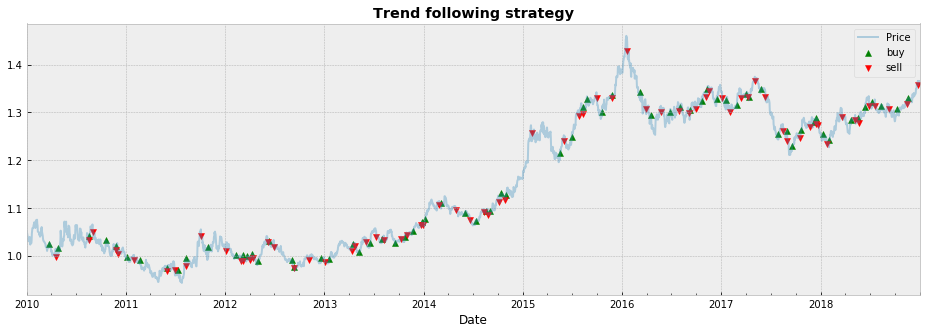

In [28]:
fig = plt.figure(figsize=(16, 5))

ax1=fig.add_subplot(111)
train['Price'].plot(alpha = 0.35)

ax2=fig.add_subplot(111)
plt.scatter(train.index, train['Price_buy'], marker = '^', color = 'g', label = 'buy')

ax3=fig.add_subplot(111)
plt.scatter(train.index, train['Price_sell'], marker = 'v', color = 'r', label = 'sell')

plt.title("Trend following strategy", weight="bold")
plt.legend()

plt.show()

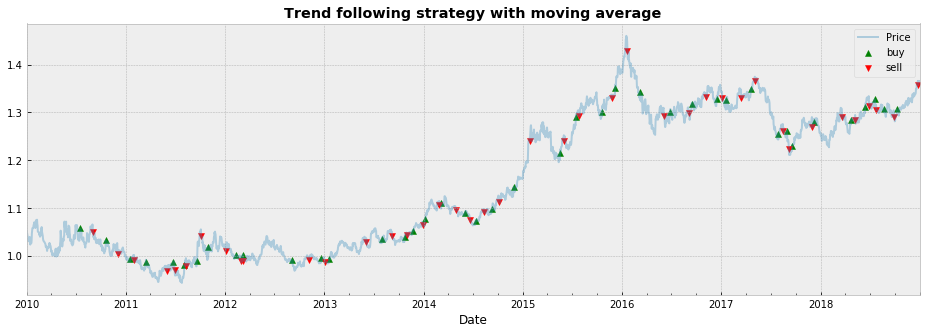

In [29]:
fig = plt.figure(figsize=(16, 5))

ax1=fig.add_subplot(111)
train['Price'].plot(alpha = 0.35)

ax2=fig.add_subplot(111)
plt.scatter(train.index, train['Price_buy_ma'], marker = '^', color = 'g', label = 'buy')

ax3=fig.add_subplot(111)
plt.scatter(train.index, train['Price_sell_ma'], marker = 'v', color = 'r', label = 'sell')

plt.title("Trend following strategy with moving average", weight="bold")
plt.legend()

plt.show()

### Drawdowm check

In [30]:
def day_week_hits():
    day_flag = True
    week_flag = True
    
    for i in range(len(data)-7):
        if data['Price'][i]*0.995 > data['Price'][i+1]:
            day_flag = False
        if data['Price'][i]*0.98 > data['Price'][i+7]:
            week_flag = False
    return day_flag, week_flag

In [31]:
day_week_hits()

(False, False)

### Backtesting

In [32]:
def calc_hits(data, w):
    data['Hits'+w] = data['VaR_' + w] - data['Returns'] > 0

In [33]:
def zone(p):
    if p > 0.05:
        return 'green'
    elif p > 0.0001:
        return 'yellow'
    else:
        return 'red'

In [34]:
def backtest_VaR(data, w):
    calc_hits(data,w)    
    level = 0.05
    sum_hits = sum(data['Hits'+w])
    len_hits = len(data)
    p_value_two_sided = ss.binom_test(sum(data['Hits'+w]), len(data['Hits'+w]), level, alternative = 'two-sided')
    p_value_conservative = ss.binom_test(sum(data['Hits'+w]), len(data['Hits'+w]), level, alternative = 'greater')
    print('Backtesting value-at-risk:')
    print(f'The proportion of hits is {(sum_hits/len_hits)*100:.3}% instead of expected {level*100:.3}%')
    print(f'Two-sided p-val {p_value_two_sided:.3}, one-sided: {p_value_conservative:.3}')
    print(f'{zone(p_value_two_sided)} zone\n')

In [35]:
backtest_VaR(test, '50')

Backtesting value-at-risk:
The proportion of hits is 7.33% instead of expected 5.0%
Two-sided p-val 0.0606, one-sided: 0.0378
green zone



In [36]:
print('Expected Shortfall: {:.2f}%'.format(test['Returns'][test['Hits50']].mean()))

Expected Shortfall: -0.61%


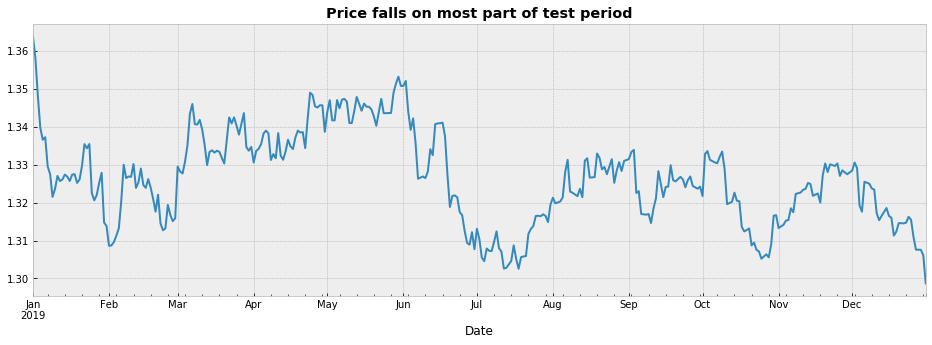

In [45]:
fig = plt.figure(figsize=(16, 5))

test['Price'].plot()
# test['Returns'].plot()
# test['Filtered_50'].plot()
plt.title("Price falls on most part of test period", weight="bold")

plt.show()

In [50]:
Sharpe_Ratio = (252**0.5) * test['Returns'].mean()/ test['Returns'].std()
print('Sharpe Ratio: {:.2f} assuming risk-free rate is zero'.format(Sharpe_Ratio))

Sharpe Ratio: -0.78 assuming risk-free rate is zero


In [38]:
def max_from_hits(data):
    max_hit = 0
    max_price = data['Price'][0]
    for i in range(len(data)):
        if data['Price'][i] > max_price:
            max_price = data['Price'][i]
        elif max_price - data['Price'][i] > max_hit:
            max_hit = (max_price - data['Price'][i])/max_price
    return max_hit

In [51]:
acc_yield = (strategy(test, '50') - 1000000)/1000000
max_hit = max_from_hits(test)
print('Accumulated capital from strategy is {:0.2f}$'.format(strategy(test, '50')))
print('Accumulated yield: {:.2f}%'.format(acc_yield*100))
print('Maximum drawdown: {:.2f}%'.format(max_hit*100))
print('Accumulated yield to maximum drawdown ratio: {:.2f}'.format(acc_yield/max_hit))

Accumulated capital from strategy is 952909.53$
Accumulated yield: -4.71%
Maximum drawdown: 4.78%
Accumulated yield to maximum drawdown ratio: -0.99


### Final results

In [46]:
print('Starting capital is 1000000$')
print('Implement strategies on 50-days rolling window from 2020-01-01 to 2020-09-04:\n')
print('Accumulated capital from strategy is {:0.2f}$'.format(strategy(final, '50')))
print('Accumulated return is {:0.2f}%'.format((strategy(final, '50')- 10**6)/10**4))
print('Accumulated capital from strategy with moving average is {:0.2f}$'.format(
    strategy_ma(final, '50')))
print('Accumulated return is {:0.2f}%'.format((strategy_ma(final, '50')- 10**6)/10**4))

Starting capital is 1000000$
Implement strategies on 50-days rolling window from 2020-01-01 to 2020-09-04:

Accumulated capital from strategy is 1000680.65$
Accumulated return is 0.07%
Accumulated capital from strategy with moving average is 988950.99$
Accumulated return is -1.10%


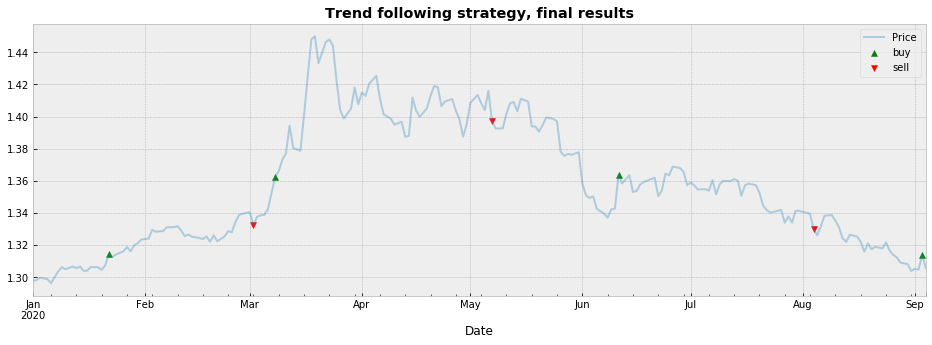

In [47]:
fig = plt.figure(figsize=(16, 5))

ax1=fig.add_subplot(111)
final['Price'].plot(alpha = 0.35)

ax2=fig.add_subplot(111)
plt.scatter(final.index, final['Price_buy'], marker = '^', color = 'g', label = 'buy')

ax3=fig.add_subplot(111)
plt.scatter(final.index, final['Price_sell'], marker = 'v', color = 'r', label = 'sell')

plt.title("Trend following strategy, final results", weight="bold")
plt.legend()

plt.show()